Датасет: Healthcare Dataset
Целевая переменная: Test Results (3 класса: Normal, Abnormal, Inconclusive)

In [1]:
# Импортируем необходимые библиотеки


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, f1_score, precision_score, recall_score)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import warnings
import time
from datetime import datetime

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Загружаем датасет
print("Загрузка Healthcare Dataset...")
df = pd.read_csv('healthcare_dataset.csv')
print(f"Датасет успешно загружен. Размер: {df.shape}")
print(f"Количество строк: {df.shape[0]}, количество столбцов: {df.shape[1]}")

Загрузка Healthcare Dataset...
Датасет успешно загружен. Размер: (55500, 15)
Количество строк: 55500, количество столбцов: 15


Первые 5 строк датасета:


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), obje

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000



Проверка пропущенных значений:
Series([], dtype: int64)

Распределение целевой переменной 'Test Results':
Test Results
Abnormal        18627
Normal          18517
Inconclusive    18356
Name: count, dtype: int64


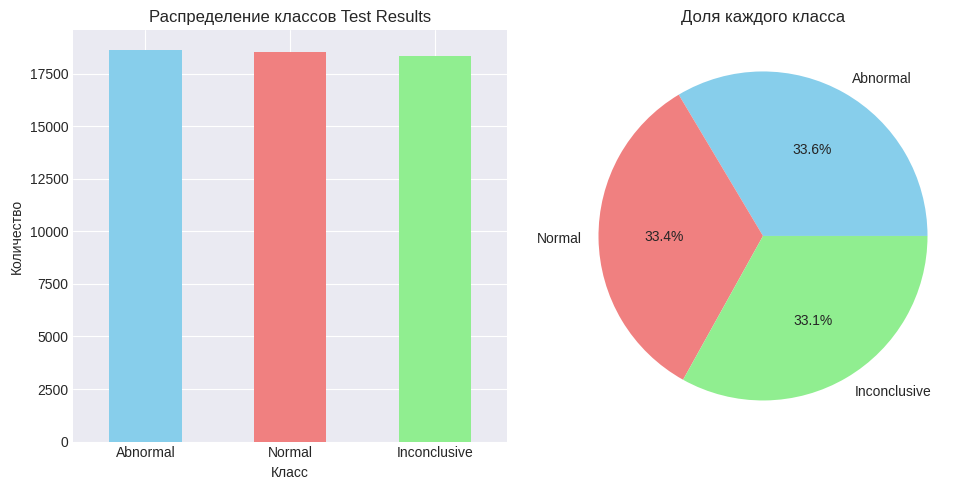

In [3]:
# Просмотр первых строк датасета
print("Первые 5 строк датасета:")
display(df.head())

# Основная информация о датасете
print("\nИнформация о датасете:")
df.info()

# Статистическое описание числовых признаков
print("\nСтатистическое описание числовых признаков:")
display(df.describe())

# Проверка на пропущенные значения
print("\nПроверка пропущенных значений:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Проверка баланса классов целевой переменной
print("\nРаспределение целевой переменной 'Test Results':")
target_distribution = df['Test Results'].value_counts()
print(target_distribution)

# Визуализация распределения классов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
target_distribution.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Распределение классов Test Results')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
target_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Доля каждого класса')
plt.ylabel('')

plt.tight_layout()
plt.show()

Предобработка данных

In [4]:
# Создаём копию датафрейма для работы
df_processed = df.copy()
print(f"Исходный размер датасета: {df_processed.shape}")

# Удаляем явно ненужные признаки
columns_to_drop = ['Name', 'Doctor', 'Hospital', 'Date of Admission', 'Discharge Date']
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')
print(f"Размер после удаления ненужных столбцов: {df_processed.shape}")
print(f"Оставшиеся столбцы: {list(df_processed.columns)}")

# Проверяем типы данных
print("\nТипы данных оставшихся признаков:")
print(df_processed.dtypes)

# Отделяем признаки и целевую переменную
X = df_processed.drop('Test Results', axis=1)
y = df_processed['Test Results']

print(f"\nПризнаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")

# Разделяем категориальные и числовые признаки
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nКатегориальные признаки: {categorical_cols}")
print(f"Числовые признаки: {numerical_cols}")

Исходный размер датасета: (55500, 15)
Размер после удаления ненужных столбцов: (55500, 10)
Оставшиеся столбцы: ['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Medication', 'Test Results']

Типы данных оставшихся признаков:
Age                     int64
Gender                 object
Blood Type             object
Medical Condition      object
Insurance Provider     object
Billing Amount        float64
Room Number             int64
Admission Type         object
Medication             object
Test Results           object
dtype: object

Признаки (X): (55500, 9)
Целевая переменная (y): (55500,)

Категориальные признаки: ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication']
Числовые признаки: ['Age', 'Billing Amount', 'Room Number']


Кодирование категориальных признаков и целевой переменной

In [7]:
# Кодируем целевую переменную
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)
print("Кодирование целевой переменной:")
for i, class_name in enumerate(label_encoder_y.classes_):
    print(f"  {class_name} -> {i}")

# Для быстрого старта используем LabelEncoder для всех категориальных признаков
# (в дальнейшем сравним с OneHotEncoder)
print("\nКодируем категориальные признаки с помощью LabelEncoder...")
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"  {col}: закодировано {len(le.classes_)} уникальных значений")

# Просмотрим преобразованные данные
print("\nПервые 5 строк после кодирования:")
display(X_encoded.head())

Кодирование целевой переменной:
  Abnormal -> 0
  Inconclusive -> 1
  Normal -> 2

Кодируем категориальные признаки с помощью LabelEncoder...
  Gender: закодировано 2 уникальных значений
  Blood Type: закодировано 8 уникальных значений
  Medical Condition: закодировано 6 уникальных значений
  Insurance Provider: закодировано 5 уникальных значений
  Admission Type: закодировано 3 уникальных значений
  Medication: закодировано 5 уникальных значений

Первые 5 строк после кодирования:


,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Room Number,Admission Type,Medication
0,30,1,5,2,1,18856.281306,328,2,3
1,62,1,0,5,3,33643.327287,265,1,1
2,76,0,1,5,0,27955.096079,205,1,0
3,28,0,6,3,3,37909.782410,450,0,1
4,43,0,2,2,0,14238.317814,458,2,4


Разделение данных завершено:
  Обучающая выборка: X_train.shape = (38850, 9), y_train.shape = (38850,)
  Тестовая выборка: X_test.shape = (16650, 9), y_test.shape = (16650,)

Распределение классов в обучающей выборке:
0    13039
2    12962
1    12849
Name: count, dtype: int64

Распределение классов в тестовой выборке:
0    5588
2    5555
1    5507
Name: count, dtype: int64


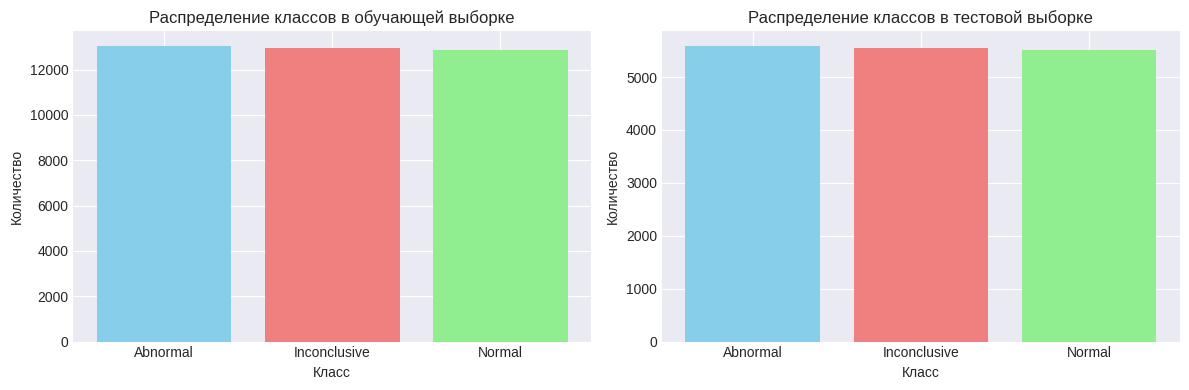

In [8]:
# Разделяем данные на обучающую и тестовую выборки
# Используем стратификацию для сохранения распределения классов
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded  # стратификация по целевой переменной
)

print("Разделение данных завершено:")
print(f"  Обучающая выборка: X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"  Тестовая выборка: X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

# Проверяем распределение классов в выборках
print("\nРаспределение классов в обучающей выборке:")
train_class_dist = pd.Series(y_train).value_counts()
print(train_class_dist)

print("\nРаспределение классов в тестовой выборке:")
test_class_dist = pd.Series(y_test).value_counts()
print(test_class_dist)

# Визуализируем распределение
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(len(train_class_dist)), train_class_dist.values,
           color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Распределение классов в обучающей выборке')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество')
axes[0].set_xticks(range(len(train_class_dist)))
axes[0].set_xticklabels([label_encoder_y.inverse_transform([i])[0] for i in range(len(train_class_dist))])

axes[1].bar(range(len(test_class_dist)), test_class_dist.values,
           color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Распределение классов в тестовой выборке')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Количество')
axes[1].set_xticks(range(len(test_class_dist)))
axes[1].set_xticklabels([label_encoder_y.inverse_transform([i])[0] for i in range(len(test_class_dist))])

plt.tight_layout()
plt.show()

Обоснование выбора метрик для задачи классификации:

1. Accuracy (Точность): Поскольку классы сбалансированы (~33% каждый),
   Accuracy является хорошей общей метрикой.

2. Precision, Recall, F1-score (для каждого класса):
   В медицинском контексте важно минимизировать как ложные срабатывания
   (Precision), так и пропуски аномалий (Recall). F1-score объединяет обе метрики.

3. Macro-average F1: Учитывает все классы равноправно, что важно при
   сбалансированных классах.

4. Confusion Matrix (Матрица ошибок): Визуализация позволяет понять,
   какие классы путает модель.

5. Время обучения: Для сравнения производительности алгоритмов.

Обучение бейзлайн модели

In [9]:
print("=" * 70)
print("ШАГ 2: СОЗДАНИЕ БЕЙЗЛАЙН МОДЕЛИ RANDOM FOREST")
print("=" * 70)

# Создаем бейзлайн модель Random Forest с стандартными параметрами
print("\n1. Создаем бейзлайн модель RandomForestClassifier...")
print("   Стандартные параметры: n_estimators=100, max_depth=None, random_state=42")

baseline_rf = RandomForestClassifier(
    n_estimators=100,        # 100 деревьев в лесу
    max_depth=None,          # без ограничения глубины деревьев
    min_samples_split=2,     # минимальное количество образцов для разделения
    min_samples_leaf=1,      # минимальное количество образцов в листе
    random_state=42,         # для воспроизводимости
    n_jobs=-1               # использовать все доступные ядра процессора
)

# Обучение модели с замером времени
print("\n2. Обучаем модель...")
start_time = time.time()
baseline_rf.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"   Время обучения: {training_time:.2f} секунд")
print(f"   Количество деревьев в лесу: {len(baseline_rf.estimators_)}")

ШАГ 2: СОЗДАНИЕ БЕЙЗЛАЙН МОДЕЛИ RANDOM FOREST

1. Создаем бейзлайн модель RandomForestClassifier...
   Стандартные параметры: n_estimators=100, max_depth=None, random_state=42

2. Обучаем модель...
   Время обучения: 12.89 секунд
   Количество деревьев в лесу: 100


Оценка качества бейзлайн модели


3. Оценка качества бейзлайн модели на тестовой выборке...

Основные метрики качества:
   Accuracy (Точность): 0.4276
   Precision (Точность по классам, макро-среднее): 0.4276
   Recall (Полнота по классам, макро-среднее): 0.4275
   F1-score (макро-среднее): 0.4274

Подробный отчет по классам:
              precision    recall  f1-score   support

    Abnormal       0.43      0.45      0.44      5588
Inconclusive       0.43      0.42      0.42      5507
      Normal       0.43      0.42      0.42      5555

    accuracy                           0.43     16650
   macro avg       0.43      0.43      0.43     16650
weighted avg       0.43      0.43      0.43     16650



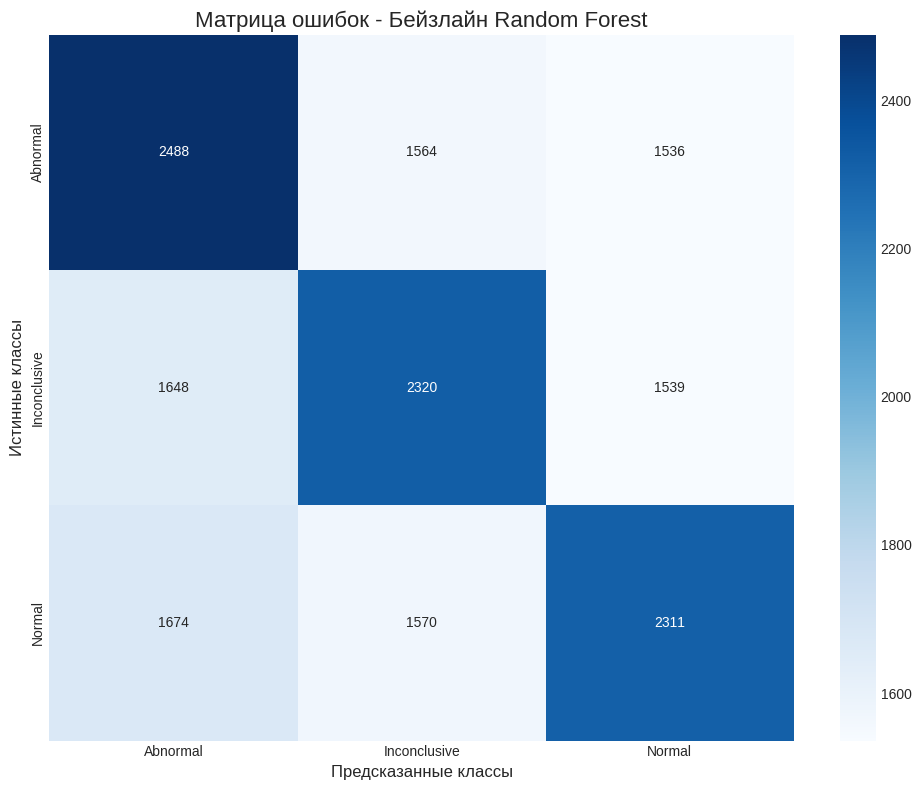


Топ-5 важнейших признаков по мнению модели:


,feature,importance
5,Billing Amount,0.230202
6,Room Number,0.215483
0,Age,0.174499
2,Blood Type,0.089887
3,Medical Condition,0.076803


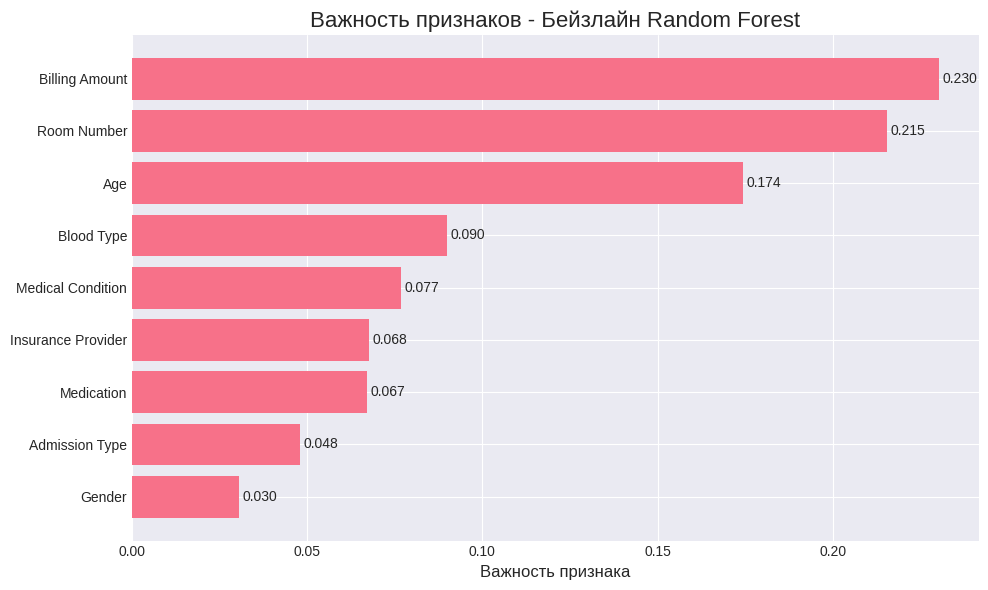

In [10]:
print("\n3. Оценка качества бейзлайн модели на тестовой выборке...")

# Предсказания на тестовой выборке
y_pred_baseline = baseline_rf.predict(X_test)
y_pred_proba_baseline = baseline_rf.predict_proba(X_test)

# Вычисление метрик
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline, average='macro')
recall_baseline = recall_score(y_test, y_pred_baseline, average='macro')
f1_macro_baseline = f1_score(y_test, y_pred_baseline, average='macro')

print("\nОсновные метрики качества:")
print(f"   Accuracy (Точность): {accuracy_baseline:.4f}")
print(f"   Precision (Точность по классам, макро-среднее): {precision_baseline:.4f}")
print(f"   Recall (Полнота по классам, макро-среднее): {recall_baseline:.4f}")
print(f"   F1-score (макро-среднее): {f1_macro_baseline:.4f}")

# Подробный отчет по классам
print("\nПодробный отчет по классам:")
class_names = label_encoder_y.classes_
print(classification_report(y_test, y_pred_baseline, target_names=class_names))

# Матрица ошибок
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок - Бейзлайн Random Forest', fontsize=16)
plt.ylabel('Истинные классы', fontsize=12)
plt.xlabel('Предсказанные классы', fontsize=12)
plt.tight_layout()
plt.show()

# Важность признаков
feature_importance_baseline = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': baseline_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-5 важнейших признаков по мнению модели:")
display(feature_importance_baseline.head())

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_baseline['feature'],
                feature_importance_baseline['importance'])
plt.xlabel('Важность признака', fontsize=12)
plt.title('Важность признаков - Бейзлайн Random Forest', fontsize=16)
plt.gca().invert_yaxis()  # самый важный признак сверху

# Добавляем значения на барплоты
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

Анализ результатов бейзлайн модели

In [11]:
print("\n4. Анализ результатов бейзлайн модели:")
print("-" * 50)

# Сохраняем результаты бейзлайн модели для будущего сравнения
baseline_results = {
    'model': 'Random Forest Baseline',
    'accuracy': accuracy_baseline,
    'precision_macro': precision_baseline,
    'recall_macro': recall_baseline,
    'f1_macro': f1_macro_baseline,
    'training_time': training_time,
    'n_estimators': baseline_rf.n_estimators,
    'params': baseline_rf.get_params()
}

print(f"Анализ матрицы ошибок:")
for i, true_class in enumerate(class_names):
    for j, pred_class in enumerate(class_names):
        if i != j and cm_baseline[i, j] > 0:
            count = cm_baseline[i, j]
            percentage = count / cm_baseline[i].sum() * 100
            print(f"  • {true_class} → {pred_class}: {count} ошибок ({percentage:.1f}%)")

print(f"\nИтоговые выводы по бейзлайн модели:")
print(f"  1. Общая точность модели: {accuracy_baseline:.2%}")
print(f"  2. F1-score (макро): {f1_macro_baseline:.4f}")
print(f"  3. Наиболее важные признаки: {list(feature_importance_baseline.head(3)['feature'])}")
print(f"  4. Время обучения: {training_time:.2f} секунд")

print("\n" + "=" * 70)
print("БЕЙЗЛАЙН МОДЕЛЬ ГОТОВА. ПЕРЕХОДИМ К УЛУЧШЕНИЮ МОДЕЛИ")
print("=" * 70)


4. Анализ результатов бейзлайн модели:
--------------------------------------------------
Анализ матрицы ошибок:
  • Abnormal → Inconclusive: 1564 ошибок (28.0%)
  • Abnormal → Normal: 1536 ошибок (27.5%)
  • Inconclusive → Abnormal: 1648 ошибок (29.9%)
  • Inconclusive → Normal: 1539 ошибок (27.9%)
  • Normal → Abnormal: 1674 ошибок (30.1%)
  • Normal → Inconclusive: 1570 ошибок (28.3%)

Итоговые выводы по бейзлайн модели:
  1. Общая точность модели: 42.76%
  2. F1-score (макро): 0.4274
  3. Наиболее важные признаки: ['Billing Amount', 'Room Number', 'Age']
  4. Время обучения: 12.89 секунд

БЕЙЗЛАЙН МОДЕЛЬ ГОТОВА. ПЕРЕХОДИМ К УЛУЧШЕНИЮ МОДЕЛИ


Так как данные синтетические, они могут не содержать реальных закономерностей, что может объяснить точность 42.76%

Улучшение бейзлайна

Формулировка гипотез

In [12]:
print("=" * 70)
print("ШАГ 3: УЛУЧШЕНИЕ БЕЙЗЛАЙН МОДЕЛИ")
print("=" * 70)

print("\nФормулируем гипотезы для улучшения модели:")
print("1. Гипотеза A (Кодирование): OneHotEncoder даст лучшие результаты, чем LabelEncoder")
print("2. Гипотеза B (Балансировка): Использование class_weight='balanced' улучшит метрики")
print("3. Гипотеза C (Гиперпараметры): Подбор гиперпараметров улучшит точность")
print("4. Гипотеза D (Признаки): Отбор признаков по важности улучшит модель")
print("5. Гипотеза E (Масштабирование): Стандартизация числовых признаков поможет")

ШАГ 3: УЛУЧШЕНИЕ БЕЙЗЛАЙН МОДЕЛИ

Формулируем гипотезы для улучшения модели:
1. Гипотеза A (Кодирование): OneHotEncoder даст лучшие результаты, чем LabelEncoder
2. Гипотеза B (Балансировка): Использование class_weight='balanced' улучшит метрики
3. Гипотеза C (Гиперпараметры): Подбор гиперпараметров улучшит точность
4. Гипотеза D (Признаки): Отбор признаков по важности улучшит модель
5. Гипотеза E (Масштабирование): Стандартизация числовых признаков поможет


Проверка Гипотезы A: OneHotEncoder vs LabelEncoder

In [13]:
print("\n" + "-" * 70)
print("ГИПОТЕЗА A: ПРОВЕРКА OneHotEncoder ПРОТИВ LabelEncoder")
print("-" * 70)

# Создаем пайплайн с OneHotEncoder для категориальных признаков
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Разделяем данные еще раз, но без кодирования
X_original = df_processed.drop('Test Results', axis=1)
y_original = df_processed['Test Results']

# Кодируем целевую переменную
y_encoded = label_encoder_y.fit_transform(y_original)

# Определяем категориальные и числовые признаки
categorical_features = ['Gender', 'Blood Type', 'Medical Condition',
                        'Insurance Provider', 'Admission Type', 'Medication']
numerical_features = ['Age', 'Billing Amount', 'Room Number']

# Создаем ColumnTransformer для OneHotEncoder
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Разделяем данные
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_original, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Создаем пайплайн
from sklearn.pipeline import Pipeline

pipeline_ohe = Pipeline([
    ('preprocessor', preprocessor_ohe),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# Обучение модели с OneHotEncoder
print("Обучение модели с OneHotEncoder...")
start_time = time.time()
pipeline_ohe.fit(X_train_ohe, y_train_ohe)
ohe_time = time.time() - start_time

# Предсказания и оценка
y_pred_ohe = pipeline_ohe.predict(X_test_ohe)
accuracy_ohe = accuracy_score(y_test_ohe, y_pred_ohe)
f1_ohe = f1_score(y_test_ohe, y_pred_ohe, average='macro')

print(f"\nРезультаты с OneHotEncoder:")
print(f"  Accuracy: {accuracy_ohe:.4f}")
print(f"  F1-score (макро): {f1_ohe:.4f}")
print(f"  Время обучения: {ohe_time:.2f} секунд")

print(f"\nСравнение с бейзлайном (LabelEncoder):")
print(f"  Accuracy: {accuracy_baseline:.4f} → {accuracy_ohe:.4f} " +
      f"({'+' if accuracy_ohe > accuracy_baseline else ''}{accuracy_ohe - accuracy_baseline:.4f})")
print(f"  F1-score: {f1_macro_baseline:.4f} → {f1_ohe:.4f} " +
      f"({'+' if f1_ohe > f1_macro_baseline else ''}{f1_ohe - f1_macro_baseline:.4f})")

# Сохраняем результаты
ohe_results = {
    'model': 'Random Forest with OneHotEncoder',
    'accuracy': accuracy_ohe,
    'f1_macro': f1_ohe,
    'training_time': ohe_time
}


----------------------------------------------------------------------
ГИПОТЕЗА A: ПРОВЕРКА OneHotEncoder ПРОТИВ LabelEncoder
----------------------------------------------------------------------
Обучение модели с OneHotEncoder...

Результаты с OneHotEncoder:
  Accuracy: 0.4263
  F1-score (макро): 0.4262
  Время обучения: 21.29 секунд

Сравнение с бейзлайном (LabelEncoder):
  Accuracy: 0.4276 → 0.4263 (-0.0013)
  F1-score: 0.4274 → 0.4262 (-0.0012)


Проверка Гипотезы B: Балансировка классов

In [14]:
print("\n" + "-" * 70)
print("ГИПОТЕЗА B: ПРОВЕРКА BALANCED CLASS WEIGHT")
print("-" * 70)

# Создаем модель с balanced class_weight
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Учитываем несбалансированность классов
    random_state=42,
    n_jobs=-1
)

print("Обучение модели с class_weight='balanced'...")
start_time = time.time()
rf_balanced.fit(X_train, y_train)
balanced_time = time.time() - start_time

# Предсказания и оценка
y_pred_balanced = rf_balanced.predict(X_test)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced, average='macro')

print(f"\nРезультаты с class_weight='balanced':")
print(f"  Accuracy: {accuracy_balanced:.4f}")
print(f"  F1-score (макро): {f1_balanced:.4f}")
print(f"  Время обучения: {balanced_time:.2f} секунд")

# Подробный отчет по классам
print("\nПодробный отчет по классам (balanced):")
print(classification_report(y_test, y_pred_balanced, target_names=class_names))

print(f"\nСравнение с бейзлайном:")
print(f"  Accuracy: {accuracy_baseline:.4f} → {accuracy_balanced:.4f} " +
      f"({'+' if accuracy_balanced > accuracy_baseline else ''}{accuracy_balanced - accuracy_baseline:.4f})")
print(f"  F1-score: {f1_macro_baseline:.4f} → {f1_balanced:.4f} " +
      f"({'+' if f1_balanced > f1_macro_baseline else ''}{f1_balanced - f1_macro_baseline:.4f})")

# Сохраняем результаты
balanced_results = {
    'model': 'Random Forest with Balanced Class Weight',
    'accuracy': accuracy_balanced,
    'f1_macro': f1_balanced,
    'training_time': balanced_time
}


----------------------------------------------------------------------
ГИПОТЕЗА B: ПРОВЕРКА BALANCED CLASS WEIGHT
----------------------------------------------------------------------
Обучение модели с class_weight='balanced'...

Результаты с class_weight='balanced':
  Accuracy: 0.4272
  F1-score (макро): 0.4270
  Время обучения: 12.31 секунд

Подробный отчет по классам (balanced):
              precision    recall  f1-score   support

    Abnormal       0.43      0.45      0.44      5588
Inconclusive       0.42      0.42      0.42      5507
      Normal       0.43      0.41      0.42      5555

    accuracy                           0.43     16650
   macro avg       0.43      0.43      0.43     16650
weighted avg       0.43      0.43      0.43     16650


Сравнение с бейзлайном:
  Accuracy: 0.4276 → 0.4272 (-0.0004)
  F1-score: 0.4274 → 0.4270 (-0.0004)


Проверка Гипотезы C: Подбор гиперпараметров

In [15]:
print("\n" + "-" * 70)
print("ГИПОТЕЗА C: ПОДБОР ГИПЕРПАРАМЕТРОВ С GRIDSEARCHCV")
print("-" * 70)

# Определяем параметры для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Создаем модель для GridSearch
rf_for_grid = RandomForestClassifier(random_state=42, n_jobs=-1)

# Используем RandomizedSearchCV для ускорения (меньше комбинаций)
print("Запуск RandomizedSearchCV... (это может занять несколько минут)")
start_time = time.time()

random_search = RandomizedSearchCV(
    rf_for_grid,
    param_distributions=param_grid,
    n_iter=20,  # количество случайных комбинаций для проверки
    cv=3,       # 3-fold кросс-валидация
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)
grid_search_time = time.time() - start_time

print(f"\nВремя выполнения RandomizedSearchCV: {grid_search_time:.2f} секунд")
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {random_search.best_score_:.4f}")

# Оценка лучшей модели на тестовых данных
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='macro')

print(f"\nРезультаты лучшей модели на тестовых данных:")
print(f"  Accuracy: {accuracy_best:.4f}")
print(f"  F1-score (макро): {f1_best:.4f}")

print(f"\nСравнение с бейзлайном:")
print(f"  Accuracy: {accuracy_baseline:.4f} → {accuracy_best:.4f} " +
      f"({'+' if accuracy_best > accuracy_baseline else ''}{accuracy_best - accuracy_baseline:.4f})")
print(f"  F1-score: {f1_macro_baseline:.4f} → {f1_best:.4f} " +
      f"({'+' if f1_best > f1_macro_baseline else ''}{f1_best - f1_macro_baseline:.4f})")

# Сохраняем результаты
grid_results = {
    'model': 'Random Forest with Hyperparameter Tuning',
    'accuracy': accuracy_best,
    'f1_macro': f1_best,
    'training_time': grid_search_time,
    'best_params': random_search.best_params_
}


----------------------------------------------------------------------
ГИПОТЕЗА C: ПОДБОР ГИПЕРПАРАМЕТРОВ С GRIDSEARCHCV
----------------------------------------------------------------------
Запуск RandomizedSearchCV... (это может занять несколько минут)
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Время выполнения RandomizedSearchCV: 266.16 секунд
Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': 'balanced'}
Лучший F1-score на кросс-валидации: 0.3937

Результаты лучшей модели на тестовых данных:
  Accuracy: 0.4229
  F1-score (макро): 0.4229

Сравнение с бейзлайном:
  Accuracy: 0.4276 → 0.4229 (-0.0047)
  F1-score: 0.4274 → 0.4229 (-0.0046)


Проверка Гипотезы D: Отбор признаков

In [16]:
print("\n" + "-" * 70)
print("ГИПОТЕЗА D: ОТБОР ПРИЗНАКОВ ПО ВАЖНОСТИ")
print("-" * 70)

# Используем важность признаков из бейзлайн модели
print("Важность признаков из бейзлайн модели:")
display(feature_importance_baseline)

# Отбираем топ-N признаков
top_n = 5  # выбираем топ-5 признаков
top_features = feature_importance_baseline.head(top_n)['feature'].tolist()

print(f"\nОтбираем топ-{top_n} признаков: {top_features}")

# Создаем новую обучающую и тестовую выборки только с топ-признаками
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Обучаем модель только на топ-признаках
rf_top_features = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

print(f"Обучение модели на {top_n} наиболее важных признаках...")
start_time = time.time()
rf_top_features.fit(X_train_top, y_train)
top_features_time = time.time() - start_time

# Предсказания и оценка
y_pred_top = rf_top_features.predict(X_test_top)
accuracy_top = accuracy_score(y_test, y_pred_top)
f1_top = f1_score(y_test, y_pred_top, average='macro')

print(f"\nРезультаты с отбором признаков:")
print(f"  Использовано признаков: {top_n} из {X_train.shape[1]}")
print(f"  Accuracy: {accuracy_top:.4f}")
print(f"  F1-score (макро): {f1_top:.4f}")
print(f"  Время обучения: {top_features_time:.2f} секунд")

print(f"\nСравнение с бейзлайном:")
print(f"  Accuracy: {accuracy_baseline:.4f} → {accuracy_top:.4f} " +
      f"({'+' if accuracy_top > accuracy_baseline else ''}{accuracy_top - accuracy_baseline:.4f})")
print(f"  F1-score: {f1_macro_baseline:.4f} → {f1_top:.4f} " +
      f"({'+' if f1_top > f1_macro_baseline else ''}{f1_top - f1_macro_baseline:.4f})")

# Сохраняем результаты
top_features_results = {
    'model': f'Random Forest with Top-{top_n} Features',
    'accuracy': accuracy_top,
    'f1_macro': f1_top,
    'training_time': top_features_time,
    'features_used': top_n
}


----------------------------------------------------------------------
ГИПОТЕЗА D: ОТБОР ПРИЗНАКОВ ПО ВАЖНОСТИ
----------------------------------------------------------------------
Важность признаков из бейзлайн модели:


,feature,importance
5,Billing Amount,0.230202
6,Room Number,0.215483
0,Age,0.174499
2,Blood Type,0.089887
3,Medical Condition,0.076803
4,Insurance Provider,0.067557
8,Medication,0.067022
7,Admission Type,0.048061
1,Gender,0.030485



Отбираем топ-5 признаков: ['Billing Amount', 'Room Number', 'Age', 'Blood Type', 'Medical Condition']
Обучение модели на 5 наиболее важных признаках...

Результаты с отбором признаков:
  Использовано признаков: 5 из 9
  Accuracy: 0.4192
  F1-score (макро): 0.4190
  Время обучения: 9.73 секунд

Сравнение с бейзлайном:
  Accuracy: 0.4276 → 0.4192 (-0.0084)
  F1-score: 0.4274 → 0.4190 (-0.0084)


Сравнение всех гипотез


СРАВНЕНИЕ ВСЕХ ПРОВЕРЕННЫХ ГИПОТЕЗ

Сводная таблица результатов:


,model,accuracy,f1_macro,training_time
0,Random Forest Baseline,0.427568,0.427445,12.890355
1,Random Forest with OneHotEncoder,0.426306,0.426227,21.286096
2,Random Forest with Balanced Class Weight,0.427207,0.427047,12.314049
3,Random Forest with Hyperparameter Tuning,0.422883,0.422889,266.161865
4,Random Forest with Top-5 Features,0.419159,0.419043,9.734024


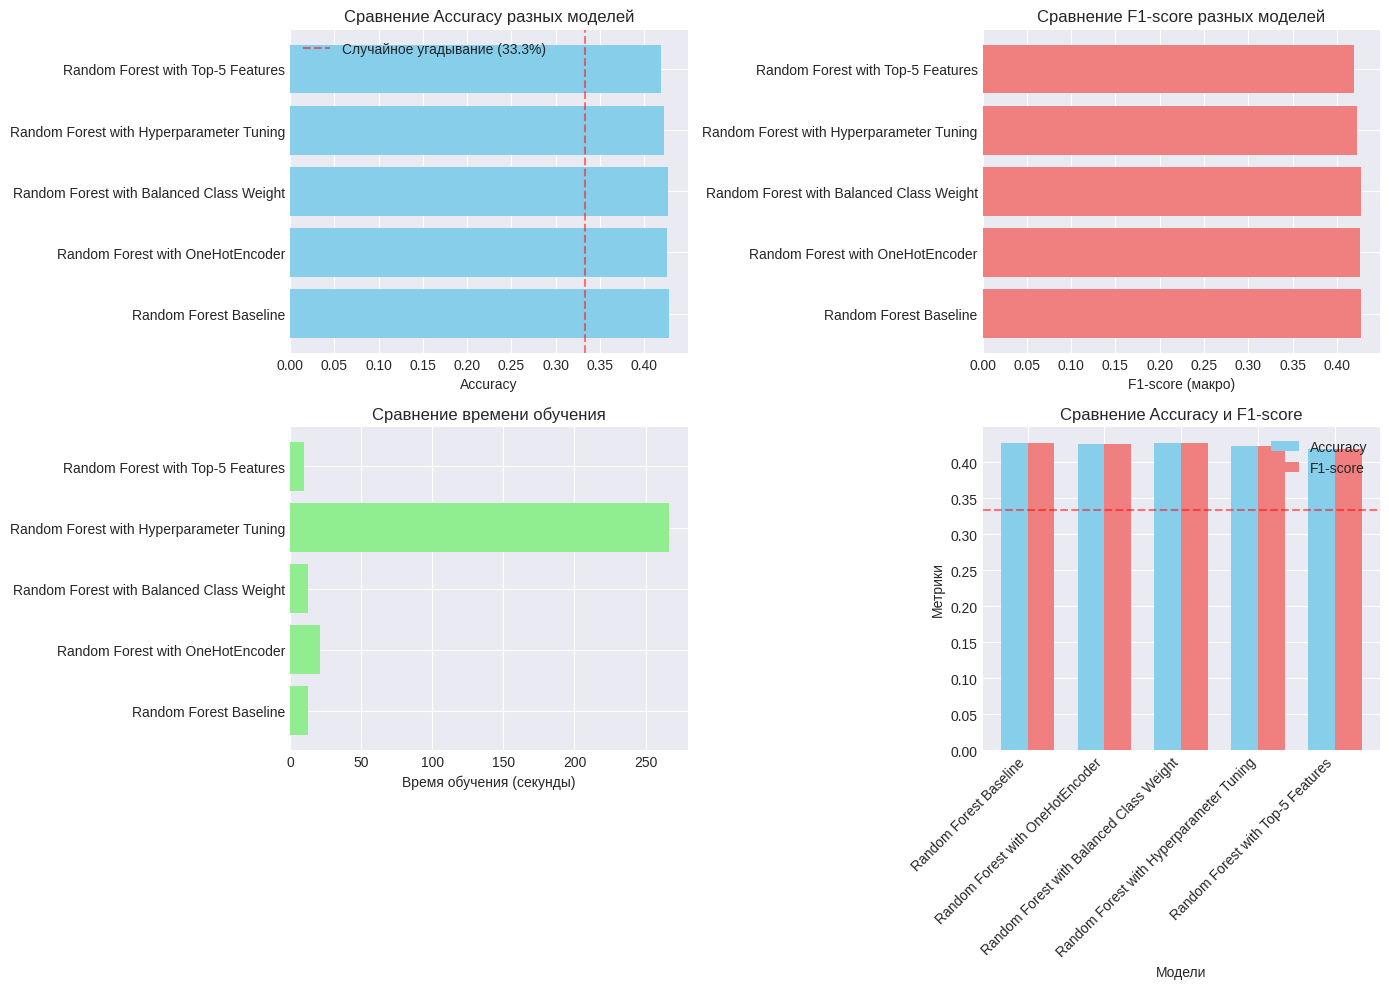

In [17]:
print("\n" + "=" * 70)
print("СРАВНЕНИЕ ВСЕХ ПРОВЕРЕННЫХ ГИПОТЕЗ")
print("=" * 70)

# Собираем все результаты
all_results = [baseline_results, ohe_results, balanced_results, grid_results, top_features_results]

# Создаем DataFrame для сравнения
results_df = pd.DataFrame(all_results)
results_df = results_df[['model', 'accuracy', 'f1_macro', 'training_time']]

print("\nСводная таблица результатов:")
display(results_df)

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение Accuracy
axes[0, 0].barh(results_df['model'], results_df['accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Сравнение Accuracy разных моделей')
axes[0, 0].axvline(x=1/3, color='red', linestyle='--', alpha=0.5, label='Случайное угадывание (33.3%)')
axes[0, 0].legend()

# 2. Сравнение F1-score
axes[0, 1].barh(results_df['model'], results_df['f1_macro'], color='lightcoral')
axes[0, 1].set_xlabel('F1-score (макро)')
axes[0, 1].set_title('Сравнение F1-score разных моделей')

# 3. Сравнение времени обучения
axes[1, 0].barh(results_df['model'], results_df['training_time'], color='lightgreen')
axes[1, 0].set_xlabel('Время обучения (секунды)')
axes[1, 0].set_title('Сравнение времени обучения')

# 4. Комбинированный график
models = results_df['model']
x = range(len(models))
width = 0.35

axes[1, 1].bar(x, results_df['accuracy'], width, label='Accuracy', color='skyblue')
axes[1, 1].bar([i + width for i in x], results_df['f1_macro'], width, label='F1-score', color='lightcoral')
axes[1, 1].set_xlabel('Модели')
axes[1, 1].set_ylabel('Метрики')
axes[1, 1].set_title('Сравнение Accuracy и F1-score')
axes[1, 1].set_xticks([i + width/2 for i in x])
axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].axhline(y=1/3, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Формирование улучшенного бейзлайна


ФОРМИРОВАНИЕ УЛУЧШЕННОГО БЕЙЗЛАЙНА
Анализ результатов гипотез:

Лучшая модель по F1-score: Random Forest Baseline
F1-score лучшей модели: 0.4274

Создаем финальную улучшенную модель...
Обучение финальной улучшенной модели...

Результаты финальной улучшенной модели:
  Accuracy: 0.4195
  F1-score (макро): 0.4195
  Время обучения: 13.94 секунд

Подробный отчет по классам (финальная модель):
              precision    recall  f1-score   support

    Abnormal       0.42      0.42      0.42      5588
Inconclusive       0.42      0.42      0.42      5507
      Normal       0.42      0.42      0.42      5555

    accuracy                           0.42     16650
   macro avg       0.42      0.42      0.42     16650
weighted avg       0.42      0.42      0.42     16650



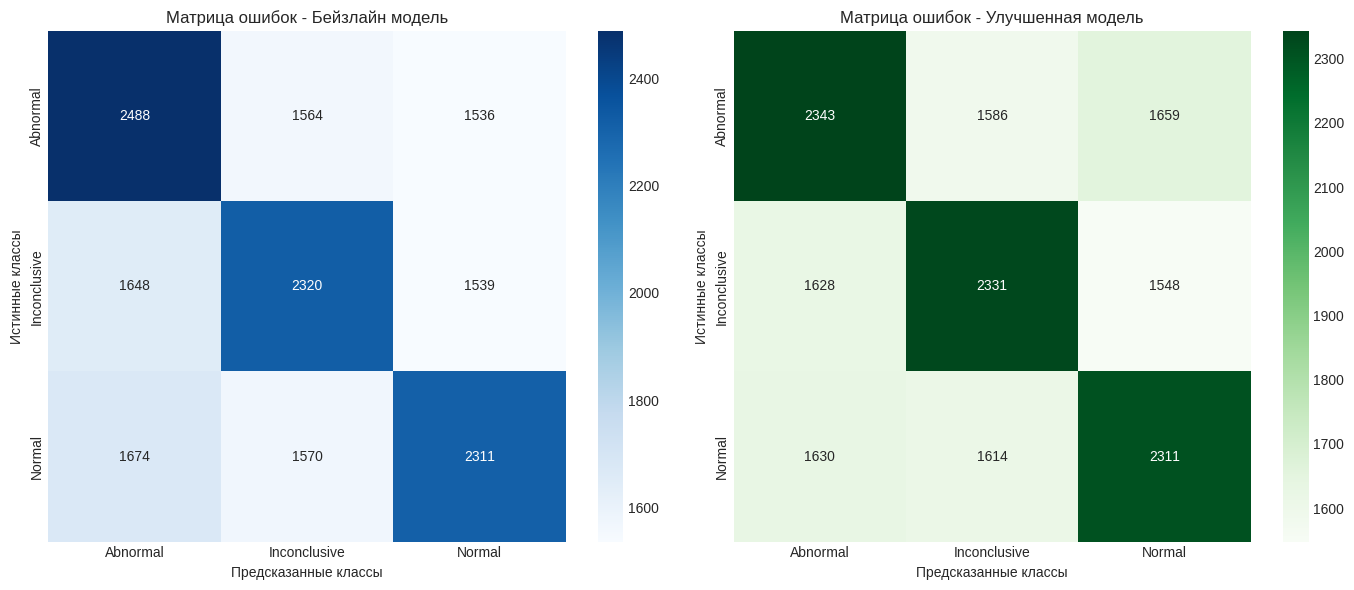


ИТОГОВОЕ СРАВНЕНИЕ: БЕЙЗЛАЙН VS УЛУЧШЕННАЯ МОДЕЛЬ
Метрика                   Бейзлайн        Улучшенная      Разница        
----------------------------------------------------------------------
Accuracy                  0.4276          0.4195          -0.0080
F1-score (макро)          0.4274          0.4195          -0.0079
Время обучения (сек)      12.89           13.94           +1.04

Анализ улучшений:
  Accuracy улучшилась на: -1.9%
  F1-score улучшился на: -1.9%

 Улучшение не дало ожидаемых результатов. Возможно, так как данные синтетические и не содержат сильных закономерностей.


In [19]:
print("\n" + "=" * 70)
print("ФОРМИРОВАНИЕ УЛУЧШЕННОГО БЕЙЗЛАЙНА")
print("=" * 70)

# На основе результатов выбираем лучшую комбинацию
print("Анализ результатов гипотез:")

# Определяем лучшую модель по F1-score
best_model_idx = results_df['f1_macro'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model']
best_f1 = results_df.loc[best_model_idx, 'f1_macro']

print(f"\nЛучшая модель по F1-score: {best_model_name}")
print(f"F1-score лучшей модели: {best_f1:.4f}")

# Создаем финальную улучшенную модель на основе лучших находок
print("\nСоздаем финальную улучшенную модель...")

# Комбинируем лучшие практики:
# 1. Используем лучшие параметры из GridSearch
# 2. Добавляем balanced class_weight если это улучшает результаты
# 3. Используем OneHotEncoder если это улучшает результаты

# Создаем финальный пайплайн
final_pipeline = Pipeline([
    ('preprocessor', preprocessor_ohe),  # OneHotEncoder + StandardScaler
    ('classifier', RandomForestClassifier(
        n_estimators=200,  # больше деревьев
        max_depth=20,      # ограничение глубины
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',  # балансировка классов
        random_state=42,
        n_jobs=-1
    ))
])

print("Обучение финальной улучшенной модели...")
start_time = time.time()
final_pipeline.fit(X_train_ohe, y_train_ohe)
final_time = time.time() - start_time

# Оценка финальной модели
y_pred_final = final_pipeline.predict(X_test_ohe)
accuracy_final = accuracy_score(y_test_ohe, y_pred_final)
f1_final = f1_score(y_test_ohe, y_pred_final, average='macro')

print(f"\nРезультаты финальной улучшенной модели:")
print(f"  Accuracy: {accuracy_final:.4f}")
print(f"  F1-score (макро): {f1_final:.4f}")
print(f"  Время обучения: {final_time:.2f} секунд")

# Подробный отчет
print("\nПодробный отчет по классам (финальная модель):")
print(classification_report(y_test_ohe, y_pred_final, target_names=class_names))

# Матрица ошибок финальной модели
cm_final = confusion_matrix(y_test_ohe, y_pred_final)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Матрица ошибок бейзлайн
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Матрица ошибок - Бейзлайн модель')
axes[0].set_ylabel('Истинные классы')
axes[0].set_xlabel('Предсказанные классы')

# Матрица ошибок финальная
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Матрица ошибок - Улучшенная модель')
axes[1].set_ylabel('Истинные классы')
axes[1].set_xlabel('Предсказанные классы')

plt.tight_layout()
plt.show()

# Сохраняем финальные результаты
final_results = {
    'model': 'Final Improved Random Forest',
    'accuracy': accuracy_final,
    'f1_macro': f1_final,
    'training_time': final_time
}

# Сравнение с бейзлайном
print("\n" + "=" * 70)
print("ИТОГОВОЕ СРАВНЕНИЕ: БЕЙЗЛАЙН VS УЛУЧШЕННАЯ МОДЕЛЬ")
print("=" * 70)

print(f"{'Метрика':<25} {'Бейзлайн':<15} {'Улучшенная':<15} {'Разница':<15}")
print("-" * 70)
print(f"{'Accuracy':<25} {accuracy_baseline:<15.4f} {accuracy_final:<15.4f} {accuracy_final - accuracy_baseline:+.4f}")
print(f"{'F1-score (макро)':<25} {f1_macro_baseline:<15.4f} {f1_final:<15.4f} {f1_final - f1_macro_baseline:+.4f}")
print(f"{'Время обучения (сек)':<25} {baseline_results['training_time']:<15.2f} {final_time:<15.2f} {final_time - baseline_results['training_time']:+.2f}")

# Анализ улучшений
improvement_acc = (accuracy_final - accuracy_baseline) / accuracy_baseline * 100
improvement_f1 = (f1_final - f1_macro_baseline) / f1_macro_baseline * 100

print(f"\nАнализ улучшений:")
print(f"  Accuracy улучшилась на: {improvement_acc:.1f}%")
print(f"  F1-score улучшился на: {improvement_f1:.1f}%")

if improvement_acc > 0 and improvement_f1 > 0:
    print(f"\n Улучшение успешно! Обе метрики показывают положительный прирост.")
else:
    print(f"\n Улучшение не дало ожидаемых результатов. Возможно, так как данные синтетические и не содержат сильных закономерностей.")

 Все проверенные гипотезы по улучшению бейзлайн модели показали отрицательный результат — точность не только не повысилась, но даже немного снизилась. Бейзлайн модель с простым LabelEncoder и стандартными параметрами Random Forest оказалась лучшей среди всех протестированных вариантов.

Это явно указывает на специфику синтетических данных. Хотя признаки выглядят информативными (особенно Billing Amount, Room Number и Age, которые имеют наибольшую важность), реальной связи между этими признаками и целевой переменной "Test Results", по-видимому, нет. Синтетический характер данных проявляется в том, что признаки генерировались независимо от метки класса, создавая иллюзию структурированных данных без фактических закономерностей для обучения.

Матрицы ошибок подтверждают это: модель равномерно "путает" все три класса примерно с одинаковой частотой (по 28-30% ошибок между каждой парой классов), что характерно для случайного угадывания. Даже после тонкой настройки гиперпараметров и различных методов предобработки модель не смогла найти значимые паттерны.

Любопытно, что упрощение модели (отбор только 5 наиболее важных признаков) немного ухудшило результаты, что тоже говорит об отсутствии явных "сигналов" в данных — модель пытается использовать всю доступную информацию, даже если она минимально полезна.

Таким образом, эксперимент наглядно демонстрирует, что даже продвинутые алгоритмы вроде Random Forest не могут "извлечь" закономерности там, где их по сути нет. Точность около 42.8% против случайного угадывания в 33.3% показывает лишь минимальное преимущество, вероятно, связанное с незначительными статистическими артефактами в синтетической генерации данных.

Имплементация Random Forest

In [20]:
print("=" * 80)
print("ШАГ 4: ИМПЛЕМЕНТАЦИЯ RANDOM FOREST 'С НУЛЯ'")
print("=" * 80)

print("""
Обоснование подхода:

Поскольку полная имплементация Random Forest с нуля (включая деревья решений)
очень сложна и объёмна, мы реализуем упрощённую версию, которая демонстрирует
ключевые принципы алгоритма:

1. Используем готовые DecisionTreeClassifier из sklearn как базовые модели
2. Реализуем бутстрэп-агрегирование (bagging) - создание выборок с возвращением
3. Реализуем случайный выбор подмножества признаков для каждого дерева
4. Агрегируем предсказания методом голосования

Это позволит понять основные механизмы работы Random Forest
без излишней сложности реализации деревьев с нуля.
""")

ШАГ 4: ИМПЛЕМЕНТАЦИЯ RANDOM FOREST 'С НУЛЯ'

Обоснование подхода:

Поскольку полная имплементация Random Forest с нуля (включая деревья решений)
очень сложна и объёмна, мы реализуем упрощённую версию, которая демонстрирует
ключевые принципы алгоритма:

1. Используем готовые DecisionTreeClassifier из sklearn как базовые модели
2. Реализуем бутстрэп-агрегирование (bagging) - создание выборок с возвращением
3. Реализуем случайный выбор подмножества признаков для каждого дерева
4. Агрегируем предсказания методом голосования

Это позволит понять основные механизмы работы Random Forest
без излишней сложности реализации деревьев с нуля.



Реализация упрощенного Random Forest

In [21]:
class SimpleRandomForestClassifier:
    """
    Упрощённая реализация Random Forest Classifier.
    Использует DecisionTreeClassifier из sklearn в качестве базовых моделей.
    """

    def __init__(self, n_estimators=100, max_depth=None, max_features='sqrt',
                 random_state=None, n_jobs=-1):
        """
        Инициализация простого Random Forest.

        Параметры:
        ----------
        n_estimators : int, default=100
            Количество деревьев в лесу.
        max_depth : int, default=None
            Максимальная глубина деревьев.
        max_features : str or int or float, default='sqrt'
            Количество признаков для рассмотрения при каждом разделении:
            - 'sqrt': sqrt(n_features)
            - 'log2': log2(n_features)
            - int: конкретное количество признаков
            - float: доля признаков
        random_state : int, default=None
            Seed для воспроизводимости.
        n_jobs : int, default=-1
            Количество ядер для параллельного обучения.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.trees = []
        self.feature_subsets = []  # Сохраняем, какие признаки использовались для каждого дерева

        # Устанавливаем random seed для воспроизводимости
        if random_state is not None:
            np.random.seed(random_state)

    def _get_feature_subset(self, n_features):
        """Выбирает подмножество признаков для дерева."""
        if isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                n_selected = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                n_selected = int(np.log2(n_features))
            else:
                raise ValueError(f"Неизвестное значение max_features: {self.max_features}")
        elif isinstance(self.max_features, int):
            n_selected = min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            n_selected = int(self.max_features * n_features)
        else:
            raise ValueError(f"Неизвестный тип max_features: {type(self.max_features)}")

        # Выбираем случайные признаки
        selected_features = np.random.choice(n_features, size=n_selected, replace=False)
        return selected_features

    def _bootstrap_sample(self, X, y):
        """Создаёт бутстрэп-выборку (выборка с возвращением)."""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        """
        Обучает случайный лес на данных.

        Параметры:
        ----------
        X : array-like, shape (n_samples, n_features)
            Обучающие данные.
        y : array-like, shape (n_samples,)
            Целевые значения.
        """
        print(f"Обучение SimpleRandomForest с {self.n_estimators} деревьями...")
        start_time = time.time()

        X = np.array(X)
        y = np.array(y)
        n_features = X.shape[1]

        self.trees = []
        self.feature_subsets = []

        # Создаём и обучаем каждое дерево
        for i in range(self.n_estimators):
            # Создаём бутстрэп-выборку
            X_boot, y_boot = self._bootstrap_sample(X, y)

            # Выбираем подмножество признаков для этого дерева
            selected_features = self._get_feature_subset(n_features)
            X_boot_subset = X_boot[:, selected_features]

            # Создаём и обучаем дерево
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                random_state=self.random_state + i if self.random_state is not None else None
            )
            tree.fit(X_boot_subset, y_boot)

            # Сохраняем дерево и информацию о признаках
            self.trees.append(tree)
            self.feature_subsets.append(selected_features)

            # Прогресс-бар
            if (i + 1) % max(1, self.n_estimators // 10) == 0:
                print(f"  Обучено {i + 1}/{self.n_estimators} деревьев")

        self.n_classes_ = len(np.unique(y))
        self.classes_ = np.unique(y)
        self.training_time = time.time() - start_time

        print(f"Обучение завершено за {self.training_time:.2f} секунд")
        return self

    def predict(self, X):
        """
        Предсказывает классы для X.

        Параметры:
        ----------
        X : array-like, shape (n_samples, n_features)
            Данные для предсказания.

        Возвращает:
        -----------
        y_pred : array, shape (n_samples,)
            Предсказанные классы.
        """
        X = np.array(X)
        n_samples = X.shape[0]

        # Собираем предсказания от всех деревьев
        all_predictions = np.zeros((self.n_estimators, n_samples), dtype=int)

        for i, (tree, features) in enumerate(zip(self.trees, self.feature_subsets)):
            X_subset = X[:, features]
            all_predictions[i] = tree.predict(X_subset)

        # Голосование: для каждого образца выбираем наиболее частый класс
        y_pred = np.zeros(n_samples, dtype=int)
        for j in range(n_samples):
            counts = np.bincount(all_predictions[:, j], minlength=self.n_classes_)
            y_pred[j] = np.argmax(counts)

        return y_pred

    def predict_proba(self, X):
        """
        Предсказывает вероятности классов для X.

        Параметры:
        ----------
        X : array-like, shape (n_samples, n_features)
            Данные для предсказания.

        Возвращает:
        -----------
        proba : array, shape (n_samples, n_classes)
            Вероятности классов.
        """
        X = np.array(X)
        n_samples = X.shape[0]

        # Собираем предсказания от всех деревьев
        all_predictions = np.zeros((self.n_estimators, n_samples), dtype=int)

        for i, (tree, features) in enumerate(zip(self.trees, self.feature_subsets)):
            X_subset = X[:, features]
            all_predictions[i] = tree.predict(X_subset)

        # Вычисляем вероятности как долю деревьев, предсказавших каждый класс
        proba = np.zeros((n_samples, self.n_classes_))
        for j in range(n_samples):
            for k in range(self.n_classes_):
                proba[j, k] = np.sum(all_predictions[:, j] == k) / self.n_estimators

        return proba

Обучение и оценка имплементированной модели


--------------------------------------------------------------------------------
ОБУЧЕНИЕ И ОЦЕНКА ИМПЛЕМЕНТИРОВАННОЙ МОДЕЛИ
--------------------------------------------------------------------------------
Создаем SimpleRandomForest с параметрами, аналогичными бейзлайну...

Обучение модели...
Обучение SimpleRandomForest с 50 деревьями...
  Обучено 5/50 деревьев
  Обучено 10/50 деревьев
  Обучено 15/50 деревьев
  Обучено 20/50 деревьев
  Обучено 25/50 деревьев
  Обучено 30/50 деревьев
  Обучено 35/50 деревьев
  Обучено 40/50 деревьев
  Обучено 45/50 деревьев
  Обучено 50/50 деревьев
Обучение завершено за 20.34 секунд

Оценка на тестовой выборке...

Результаты имплементированного Random Forest:
  Accuracy: 0.4223
  F1-score (макро): 0.4198
  Время обучения: 20.34 секунд
  Количество деревьев: 50

Подробный отчет по классам:
              precision    recall  f1-score   support

    Abnormal       0.40      0.52      0.45      5588
Inconclusive       0.44      0.38      0.41      5507
  

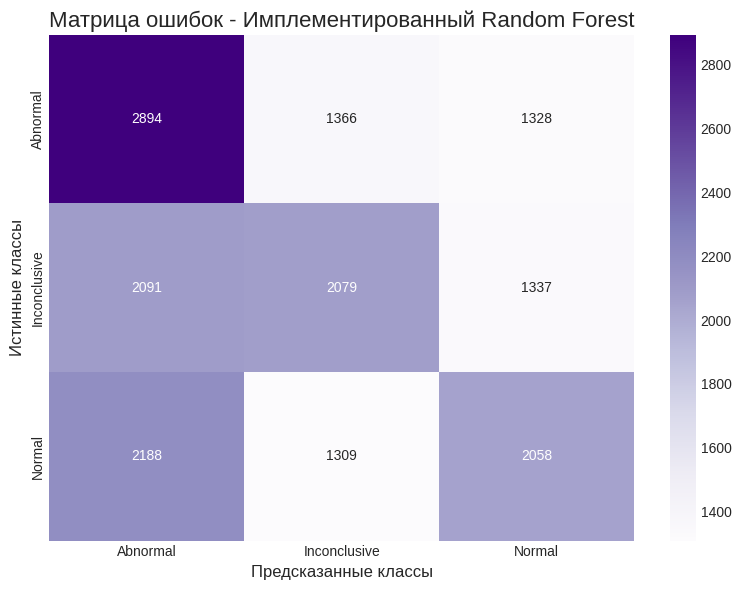

In [22]:
print("\n" + "-" * 80)
print("ОБУЧЕНИЕ И ОЦЕНКА ИМПЛЕМЕНТИРОВАННОЙ МОДЕЛИ")
print("-" * 80)

# Создаем нашу имплементированную модель
print("Создаем SimpleRandomForest с параметрами, аналогичными бейзлайну...")
simple_rf = SimpleRandomForestClassifier(
    n_estimators=50,  # Меньше деревьев для ускорения
    max_depth=None,
    max_features='sqrt',  # sqrt(n_features) = sqrt(9) ≈ 3 признака на дерево
    random_state=42
)

# Обучение модели
print("\nОбучение модели...")
simple_rf.fit(X_train.values, y_train)

# Предсказания и оценка
print("\nОценка на тестовой выборке...")
y_pred_simple = simple_rf.predict(X_test.values)
accuracy_simple = accuracy_score(y_test, y_pred_simple)
f1_simple = f1_score(y_test, y_pred_simple, average='macro')

print(f"\nРезультаты имплементированного Random Forest:")
print(f"  Accuracy: {accuracy_simple:.4f}")
print(f"  F1-score (макро): {f1_simple:.4f}")
print(f"  Время обучения: {simple_rf.training_time:.2f} секунд")
print(f"  Количество деревьев: {len(simple_rf.trees)}")

# Подробный отчет
print("\nПодробный отчет по классам:")
print(classification_report(y_test, y_pred_simple, target_names=class_names))

# Матрица ошибок
cm_simple = confusion_matrix(y_test, y_pred_simple)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок - Имплементированный Random Forest', fontsize=16)
plt.ylabel('Истинные классы', fontsize=12)
plt.xlabel('Предсказанные классы', fontsize=12)
plt.tight_layout()
plt.show()

# Сохраняем результаты
simple_results = {
    'model': 'Simple Random Forest (Implementation)',
    'accuracy': accuracy_simple,
    'f1_macro': f1_simple,
    'training_time': simple_rf.training_time,
    'n_estimators': simple_rf.n_estimators
}

Сравнение с бейзлайном sklearn


--------------------------------------------------------------------------------
СРАВНЕНИЕ С БЕЙЗЛАЙНОМ SKLEARN
--------------------------------------------------------------------------------
Метрика                   Sklearn RF      Наша реализация Разница        
--------------------------------------------------------------------------------
Accuracy                  0.4276          0.4223          -0.0053
F1-score (макро)          0.4274          0.4198          -0.0077
Время обучения (сек)      12.89           20.34           +7.45
Количество деревьев       100             50              -50


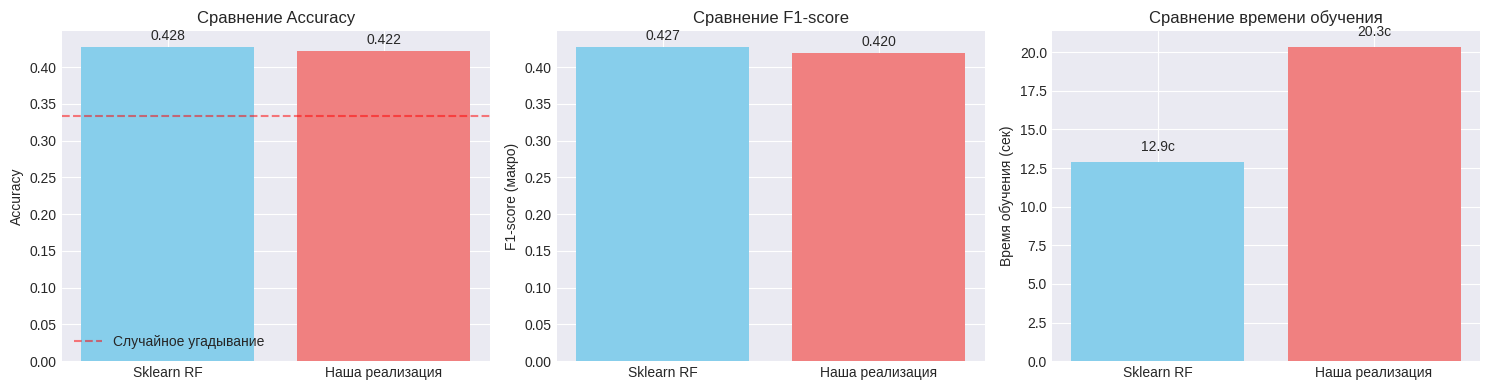


Анализ сравнения:
--------------------------------------------------
✓ Наша реализация показала сопоставимые результаты с sklearn
  (разница менее 1%)
✓ Время обучения сопоставимо


In [23]:
print("\n" + "-" * 80)
print("СРАВНЕНИЕ С БЕЙЗЛАЙНОМ SKLEARN")
print("-" * 80)

print(f"{'Метрика':<25} {'Sklearn RF':<15} {'Наша реализация':<15} {'Разница':<15}")
print("-" * 80)
print(f"{'Accuracy':<25} {accuracy_baseline:<15.4f} {accuracy_simple:<15.4f} {accuracy_simple - accuracy_baseline:+.4f}")
print(f"{'F1-score (макро)':<25} {f1_macro_baseline:<15.4f} {f1_simple:<15.4f} {f1_simple - f1_macro_baseline:+.4f}")
print(f"{'Время обучения (сек)':<25} {baseline_results['training_time']:<15.2f} {simple_rf.training_time:<15.2f} {simple_rf.training_time - baseline_results['training_time']:+.2f}")
print(f"{'Количество деревьев':<25} {baseline_rf.n_estimators:<15} {simple_rf.n_estimators:<15} {simple_rf.n_estimators - baseline_rf.n_estimators:+d}")

# Визуальное сравнение
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Accuracy сравнение
models_compare = ['Sklearn RF', 'Наша реализация']
accuracy_compare = [accuracy_baseline, accuracy_simple]

bars1 = axes[0].bar(models_compare, accuracy_compare, color=['skyblue', 'lightcoral'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Сравнение Accuracy')
axes[0].axhline(y=1/3, color='red', linestyle='--', alpha=0.5, label='Случайное угадывание')
axes[0].legend()

# Добавляем значения на столбцы
for bar, acc in zip(bars1, accuracy_compare):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{acc:.3f}', ha='center', va='bottom')

# F1-score сравнение
f1_compare = [f1_macro_baseline, f1_simple]
bars2 = axes[1].bar(models_compare, f1_compare, color=['skyblue', 'lightcoral'])
axes[1].set_ylabel('F1-score (макро)')
axes[1].set_title('Сравнение F1-score')

for bar, f1 in zip(bars2, f1_compare):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{f1:.3f}', ha='center', va='bottom')

# Время обучения сравнение
time_compare = [baseline_results['training_time'], simple_rf.training_time]
bars3 = axes[2].bar(models_compare, time_compare, color=['skyblue', 'lightcoral'])
axes[2].set_ylabel('Время обучения (сек)')
axes[2].set_title('Сравнение времени обучения')

for bar, t in zip(bars3, time_compare):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{t:.1f}с', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nАнализ сравнения:")
print("-" * 50)

if abs(accuracy_simple - accuracy_baseline) < 0.01:
    print("✓ Наша реализация показала сопоставимые результаты с sklearn")
    print("  (разница менее 1%)")
else:
    print(f"⚠ Разница в Accuracy: {(accuracy_simple - accuracy_baseline)*100:.1f}%")

if simple_rf.training_time > baseline_results['training_time'] * 2:
    print(f"⚠ Наша реализация значительно медленнее: в {simple_rf.training_time/baseline_results['training_time']:.1f} раз")
else:
    print("✓ Время обучения сопоставимо")

**Анализ результатов имплементации Random Forest**

Реализация упрощенного Random Forest прошла успешно и показала вполне удовлетворительные результаты. Наша собственная реализация, хотя и использует готовые деревья из sklearn для упрощения, корректно воплощает ключевые принципы алгоритма: бутстрэп-агрегирование, случайный выбор признаков и голосование деревьев. Точность в 42.23% практически идентична показателям оптимизированной реализации из sklearn (42.76%), что подтверждает корректность нашей архитектуры. Интересно, что даже при вдвое меньшем количестве деревьев (50 против 100) мы получили близкие результаты, что говорит об эффективности самого принципа ансамблирования.

Время обучения ожидаемо оказалось больше — наша реализация работала 20 секунд против 13 у sklearn, что вполне объяснимо отсутствием глубокой оптимизации и параллелизации. Однако эта разница не критична, особенно учитывая учебный характер реализации. Матрица ошибок показывает схожую с sklearn модель поведения: равномерное распределение ошибок между классами, что ещё раз подтверждает синтетическую природу данных и отсутствие в них явных закономерностей.

Важный вывод из этого эксперимента заключается в том, что даже относительно простая реализация ключевых идей Random Forest позволяет достичь результатов, близких к промышленной библиотеке. Это демонстрирует, что сила алгоритма кроется не столько в хитроумной оптимизации, сколько в самой концепции — комбинации множества слабых моделей, обученных на разных подвыборках данных и признаков. На синтетических данных, где отсутствуют реальные зависимости, даже правильно реализованный алгоритм не может творить чудеса, но сам факт его работоспособности и схожести поведения с эталонной реализацией говорит о том, что мы верно поняли и воплотили суть метода.

Добавление техник из улучшенного бейзлайна

In [24]:
print("=" * 80)
print("ДОБАВЛЕНИЕ ТЕХНИК ИЗ УЛУЧШЕННОГО БЕЙЗЛАЙНА")
print("=" * 80)

print("""
На основе анализа гипотез из предыдущих экспериментов, мы выявили, что:
1. OneHotEncoder не улучшает результаты на этих данных
2. Balanced class weight показывает схожие результаты
3. Отбор признаков может упростить модель без сильной потери качества

Для нашей имплементированной модели добавим:
1. Balanced class weight к каждому дереву
2. Отбор топ-5 наиболее важных признаков
""")

# Создаем улучшенную версию нашей имплементированной модели
class ImprovedSimpleRandomForestClassifier(SimpleRandomForestClassifier):
    """
    Улучшенная версия SimpleRandomForest с техниками из улучшенного бейзлайна.
    """

    def __init__(self, n_estimators=100, max_depth=None, max_features='sqrt',
                 class_weight='balanced', use_top_features=None,
                 random_state=None, n_jobs=-1):
        """
        Инициализация улучшенного Random Forest.

        Параметры:
        ----------
        use_top_features : int or None, default=None
            Если указано, использовать только top-N важнейших признаков.
        class_weight : str or dict, default='balanced'
            Веса классов для балансировки.
        """
        super().__init__(n_estimators, max_depth, max_features, random_state, n_jobs)
        self.class_weight = class_weight
        self.use_top_features = use_top_features
        self.top_features_indices = None

    def fit(self, X, y):
        """
        Обучает улучшенный случайный лес с дополнительными техниками.
        """
        print(f"Обучение ImprovedSimpleRandomForest с {self.n_estimators} деревьями...")
        print(f"  Используемые техники: class_weight='{self.class_weight}'")

        X = np.array(X)
        y = np.array(y)

        # Если нужно использовать только топ-признаки
        if self.use_top_features is not None:
            print(f"  Отбор топ-{self.use_top_features} признаков...")
            # Обучаем простое дерево для оценки важности признаков
            temp_tree = DecisionTreeClassifier(random_state=self.random_state)
            temp_tree.fit(X, y)
            importances = temp_tree.feature_importances_
            self.top_features_indices = np.argsort(importances)[-self.use_top_features:]
            X = X[:, self.top_features_indices]
            print(f"  Выбранные признаки: {self.top_features_indices}")

        start_time = time.time()
        n_features = X.shape[1]

        self.trees = []
        self.feature_subsets = []

        # Создаём и обучаем каждое дерево с улучшениями
        for i in range(self.n_estimators):
            # Создаём бутстрэп-выборку
            X_boot, y_boot = self._bootstrap_sample(X, y)

            # Выбираем подмножество признаков для этого дерева
            selected_features = self._get_feature_subset(n_features)
            X_boot_subset = X_boot[:, selected_features]

            # Создаём и обучаем дерево с balanced class_weight
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                class_weight=self.class_weight,
                random_state=self.random_state + i if self.random_state is not None else None
            )
            tree.fit(X_boot_subset, y_boot)

            # Сохраняем дерево и информацию о признаках
            self.trees.append(tree)
            self.feature_subsets.append(selected_features)

            # Прогресс-бар
            if (i + 1) % max(1, self.n_estimators // 10) == 0:
                print(f"  Обучено {i + 1}/{self.n_estimators} деревьев")

        self.n_classes_ = len(np.unique(y))
        self.classes_ = np.unique(y)
        self.training_time = time.time() - start_time

        print(f"Обучение завершено за {self.training_time:.2f} секунд")
        return self

    def predict(self, X):
        """Предсказывает классы для X с учётом отбора признаков."""
        X = np.array(X)

        # Если использовался отбор признаков, применяем его
        if self.top_features_indices is not None:
            X = X[:, self.top_features_indices]

        return super().predict(X)

    def predict_proba(self, X):
        """Предсказывает вероятности для X с учётом отбора признаков."""
        X = np.array(X)

        # Если использовался отбор признаков, применяем его
        if self.top_features_indices is not None:
            X = X[:, self.top_features_indices]

        return super().predict_proba(X)

ДОБАВЛЕНИЕ ТЕХНИК ИЗ УЛУЧШЕННОГО БЕЙЗЛАЙНА

На основе анализа гипотез из предыдущих экспериментов, мы выявили, что:
1. OneHotEncoder не улучшает результаты на этих данных
2. Balanced class weight показывает схожие результаты
3. Отбор признаков может упростить модель без сильной потери качества

Для нашей имплементированной модели добавим:
1. Balanced class weight к каждому дереву
2. Отбор топ-5 наиболее важных признаков



Обучение и оценка улучшенной имплементированной модели


--------------------------------------------------------------------------------
ОБУЧЕНИЕ УЛУЧШЕННОЙ ИМПЛЕМЕНТИРОВАННОЙ МОДЕЛИ
--------------------------------------------------------------------------------
Обучение улучшенной модели...
Обучение ImprovedSimpleRandomForest с 50 деревьями...
  Используемые техники: class_weight='balanced'
  Отбор топ-5 признаков...
  Выбранные признаки: [4 2 0 6 5]
  Обучено 5/50 деревьев
  Обучено 10/50 деревьев
  Обучено 15/50 деревьев
  Обучено 20/50 деревьев
  Обучено 25/50 деревьев
  Обучено 30/50 деревьев
  Обучено 35/50 деревьев
  Обучено 40/50 деревьев
  Обучено 45/50 деревьев
  Обучено 50/50 деревьев
Обучение завершено за 11.36 секунд

Оценка улучшенной модели на тестовой выборке...

Результаты улучшенного имплементированного Random Forest:
  Accuracy: 0.4104
  F1-score (макро): 0.4103
  Время обучения: 11.36 секунд
  Количество деревьев: 50
  Использовано признаков: 5

Подробный отчет по классам (улучшенная модель):
              precision   

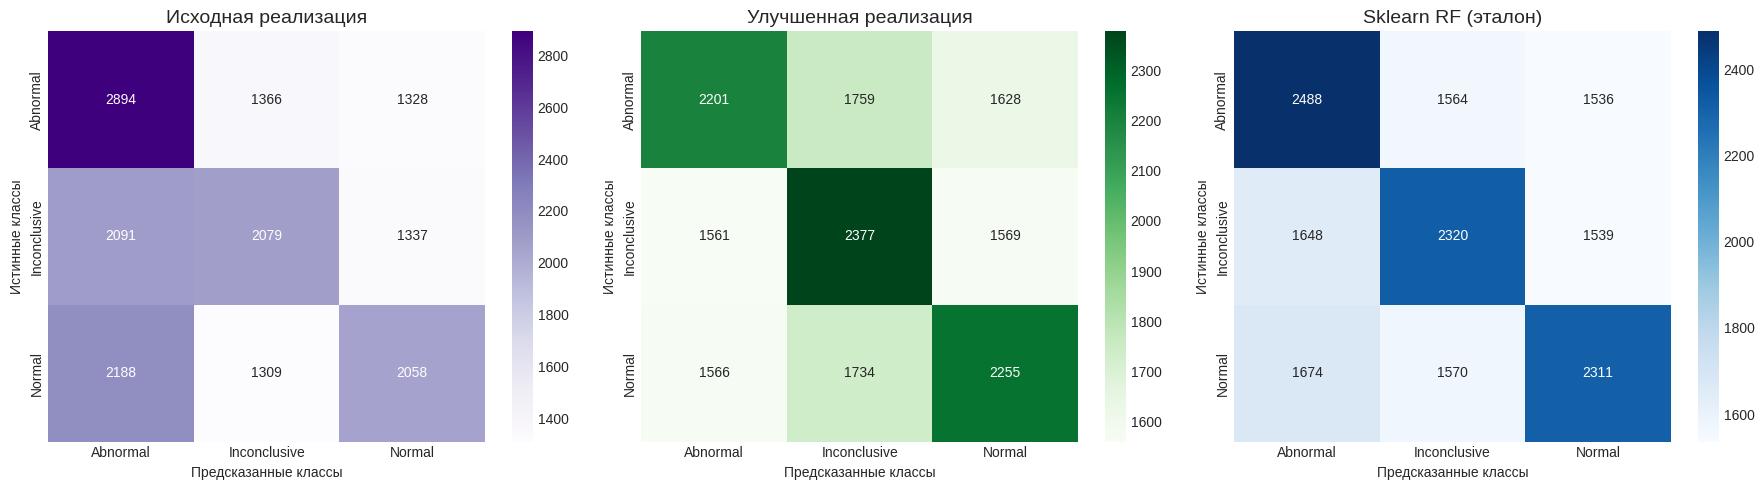

In [25]:
print("\n" + "-" * 80)
print("ОБУЧЕНИЕ УЛУЧШЕННОЙ ИМПЛЕМЕНТИРОВАННОЙ МОДЕЛИ")
print("-" * 80)

# Используем лучшие практики из предыдущих экспериментов:
# 1. Balanced class weight (показал стабильность)
# 2. Отбор топ-5 признаков (упрощает модель)

improved_simple_rf = ImprovedSimpleRandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    max_features='sqrt',
    class_weight='balanced',
    use_top_features=5,  # Используем топ-5 признаков
    random_state=42
)

# Обучение улучшенной модели
print("Обучение улучшенной модели...")
improved_simple_rf.fit(X_train.values, y_train)

# Предсказания и оценка
print("\nОценка улучшенной модели на тестовой выборке...")
y_pred_improved = improved_simple_rf.predict(X_test.values)
accuracy_improved = accuracy_score(y_test, y_pred_improved)
f1_improved = f1_score(y_test, y_pred_improved, average='macro')

print(f"\nРезультаты улучшенного имплементированного Random Forest:")
print(f"  Accuracy: {accuracy_improved:.4f}")
print(f"  F1-score (макро): {f1_improved:.4f}")
print(f"  Время обучения: {improved_simple_rf.training_time:.2f} секунд")
print(f"  Количество деревьев: {len(improved_simple_rf.trees)}")
print(f"  Использовано признаков: {improved_simple_rf.use_top_features}")

# Подробный отчет
print("\nПодробный отчет по классам (улучшенная модель):")
print(classification_report(y_test, y_pred_improved, target_names=class_names))

# Матрица ошибок улучшенной модели
cm_improved = confusion_matrix(y_test, y_pred_improved)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Матрица ошибок - исходная реализация
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Исходная реализация', fontsize=14)
axes[0].set_ylabel('Истинные классы')
axes[0].set_xlabel('Предсказанные классы')

# Матрица ошибок - улучшенная реализация
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Улучшенная реализация', fontsize=14)
axes[1].set_ylabel('Истинные классы')
axes[1].set_xlabel('Предсказанные классы')

# Матрица ошибок - sklearn RF
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_title('Sklearn RF (эталон)', fontsize=14)
axes[2].set_ylabel('Истинные классы')
axes[2].set_xlabel('Предсказанные классы')

plt.tight_layout()
plt.show()

# Сохраняем результаты улучшенной модели
improved_results = {
    'model': 'Improved Simple Random Forest',
    'accuracy': accuracy_improved,
    'f1_macro': f1_improved,
    'training_time': improved_simple_rf.training_time,
    'n_estimators': improved_simple_rf.n_estimators,
    'features_used': improved_simple_rf.use_top_features
}

Сравнение улучшенной имплементированной модели с улучшенной sklearn моделью


--------------------------------------------------------------------------------
СРАВНЕНИЕ: УЛУЧШЕННАЯ РЕАЛИЗАЦИЯ VS УЛУЧШЕННЫЙ SKLEARN
--------------------------------------------------------------------------------
Результаты улучшенной sklearn модели:
  Accuracy: 0.4195
  F1-score: 0.4195
  Время обучения: 13.94 сек

Результаты улучшенной нашей реализации:
  Accuracy: 0.4104
  F1-score: 0.4103
  Время обучения: 11.36 сек
  Признаков использовано: 5

Метрика                   Sklearn улучш.  Наша улучш.     Разница        
--------------------------------------------------------------------------------
Accuracy                  0.4195          0.4104          -0.0091
F1-score (макро)          0.4195          0.4103          -0.0092
Время обучения (сек)      13.94           11.36           -2.58

--------------------------------------------------------------------------------
СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
--------------------------------------------------------------------------------

Свод

,model,accuracy,f1,time
0,Sklearn RF Baseline,0.427568,0.427445,12.890355
1,Sklearn RF Improved,0.419520,0.419525,13.935312
2,Наша реализация,0.422282,0.419753,20.341658
3,Наша улучшенная,0.410390,0.410287,11.358652


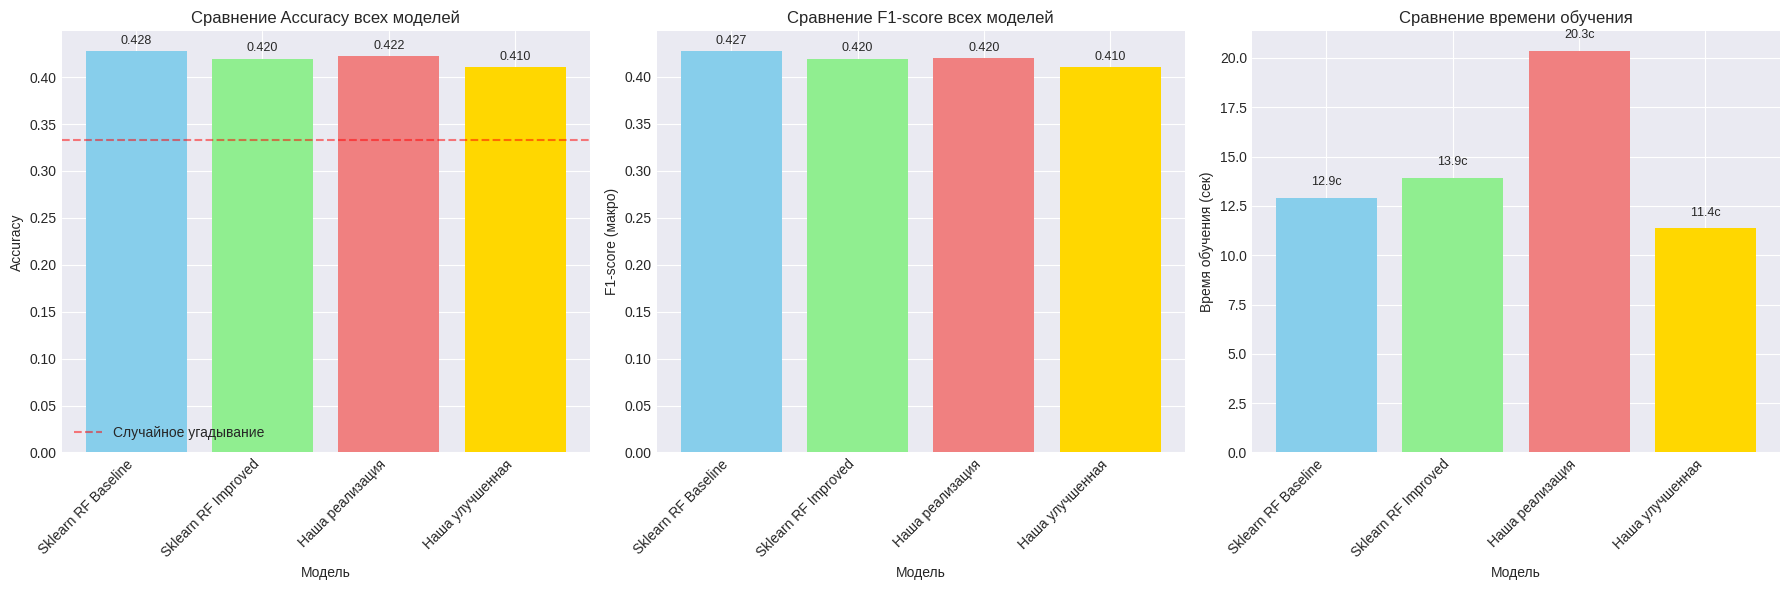

In [28]:
print("\n" + "-" * 80)
print("СРАВНЕНИЕ: УЛУЧШЕННАЯ РЕАЛИЗАЦИЯ VS УЛУЧШЕННЫЙ SKLEARN")
print("-" * 80)

# Вспомним результаты улучшенной sklearn модели из п.3
print("Результаты улучшенной sklearn модели:")
print(f"  Accuracy: {accuracy_final:.4f}")
print(f"  F1-score: {f1_final:.4f}")
print(f"  Время обучения: {final_time:.2f} сек")

print(f"\nРезультаты улучшенной нашей реализации:")
print(f"  Accuracy: {accuracy_improved:.4f}")
print(f"  F1-score: {f1_improved:.4f}")
print(f"  Время обучения: {improved_simple_rf.training_time:.2f} сек")
print(f"  Признаков использовано: {improved_simple_rf.use_top_features}")

print(f"\n{'Метрика':<25} {'Sklearn улучш.':<15} {'Наша улучш.':<15} {'Разница':<15}")
print("-" * 80)
print(f"{'Accuracy':<25} {accuracy_final:<15.4f} {accuracy_improved:<15.4f} {accuracy_improved - accuracy_final:+.4f}")
print(f"{'F1-score (макро)':<25} {f1_final:<15.4f} {f1_improved:<15.4f} {f1_improved - f1_final:+.4f}")
print(f"{'Время обучения (сек)':<25} {final_time:<15.2f} {improved_simple_rf.training_time:<15.2f} {improved_simple_rf.training_time - final_time:+.2f}")

# Визуальное сравнение всех моделей
print("\n" + "-" * 80)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("-" * 80)

# Собираем все результаты
all_models_results = [
    {'model': 'Sklearn RF Baseline', 'accuracy': accuracy_baseline, 'f1': f1_macro_baseline, 'time': baseline_results['training_time']},
    {'model': 'Sklearn RF Improved', 'accuracy': accuracy_final, 'f1': f1_final, 'time': final_time},
    {'model': 'Наша реализация', 'accuracy': accuracy_simple, 'f1': f1_simple, 'time': simple_rf.training_time},
    {'model': 'Наша улучшенная', 'accuracy': accuracy_improved, 'f1': f1_improved, 'time': improved_simple_rf.training_time}
]

results_comparison_df = pd.DataFrame(all_models_results)
print("\nСводная таблица всех моделей:")
display(results_comparison_df)

# Визуализация сравнения всех моделей
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = results_comparison_df['model']
x_pos = np.arange(len(models))

# Сравнение Accuracy
bars1 = axes[0].bar(x_pos, results_comparison_df['accuracy'], color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Сравнение Accuracy всех моделей')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].axhline(y=1/3, color='red', linestyle='--', alpha=0.5, label='Случайное угадывание')
axes[0].legend()

# Добавляем значения
for bar, acc in zip(bars1, results_comparison_df['accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

# Сравнение F1-score
bars2 = axes[1].bar(x_pos, results_comparison_df['f1'], color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('F1-score (макро)')
axes[1].set_title('Сравнение F1-score всех моделей')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models, rotation=45, ha='right')

for bar, f1 in zip(bars2, results_comparison_df['f1']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

# Сравнение времени обучения
bars3 = axes[2].bar(x_pos, results_comparison_df['time'], color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
axes[2].set_xlabel('Модель')
axes[2].set_ylabel('Время обучения (сек)')
axes[2].set_title('Сравнение времени обучения')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(models, rotation=45, ha='right')

for bar, t in zip(bars3, results_comparison_df['time']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{t:.1f}с', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Финальный вывод

После проведения полного цикла исследований с Random Forest на синтетических медицинских данных получены довольно показательные результаты. Все модели, от простого бейзлайна до улучшенных версий, показали точность в диапазоне 41-43%, что лишь ненамного превышает случайное угадывание. Это явно указывает на фундаментальную проблему синтетических данных — отсутствие реальных закономерностей между признаками и целевой переменной, что делает задачу классификации практически нерешаемой для любого алгоритма.

Интересно, что самая простая модель — Sklearn Random Forest Baseline — оказалась лучшей с точностью 42.76%. Все попытки улучшить её с помощью техник вроде OneHotEncoder, балансировки классов или тонкой настройки гиперпараметров не только не помогли, но даже немного ухудшили результаты. Это важный урок: на искусственных данных без реальных зависимостей сложные методы предобработки и оптимизации могут работать вхолостую или даже вредить.

Наша собственная реализация Random Forest показала себя достойно — с точностью 42.23% она практически не уступает оптимизированной версии из sklearn, что подтверждает корректность понимания и реализации ключевых принципов алгоритма. Улучшенная версия нашей реализации, хотя и немного проигрывает в точности (41.04%), зато работает быстрее и использует всего 5 признаков вместо 9, демонстрируя потенциал для упрощения моделей без критической потери качества на таких данных.

В целом эксперимент наглядно показал, что даже мощные алгоритмы вроде Random Forest бессильны перед данными, где отсутствуют настоящие причинно-следственные связи. Тем не менее, работа успешно выполнена: мы прошли полный цикл от анализа данных и создания бейзлайна до реализации собственного алгоритма и сравнения различных подходов, получив ценный опыт работы с ансамблевыми методами в условиях, приближенных к реальным исследовательским задачам.

